In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import cycle

from datetime import datetime

from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
!curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o nba_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9245k  100 9245k    0     0  3755k      0  0:00:02  0:00:02 --:--:-- 3753k


In [3]:
df = pd.read_csv('nba_data.csv')

In [4]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo_prob1,carm-elo_prob2,carm-elo1_post,carm-elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0
1,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0
4,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0


We'll use only date, season, teams, scores, and post game elos

In [5]:
teams = np.unique(np.append(df['team1'], df['team2']))

In [6]:
def plot_skills(items, figsize=(14.0, 3.0), title='Evolution of skill of NBA teams'):
    colors = cycle(plt.cm.tab10(np.linspace(0, 1, 10)))
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title(title)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.grid(axis='x', alpha=0.5)
    
    if isinstance(items, list):
        for team in items:
            color = next(colors)
            gpr = gprs[team]
            dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
            dates = [datetime.fromisoformat(el).timestamp() for el in dates]
            x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
            y, std = gpr.predict(x, return_std=True)

            x = [datetime.fromtimestamp(t) for t in x]
            ax.plot(x, y, color=color, label=team)
            ax.fill_between(x, y-std, y+std, color=color, alpha=0.2)
        ax.legend()
    else:
        team = items
        gpr = gprs[team]
        dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
        dates = [datetime.fromisoformat(el).timestamp() for el in dates]
        x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
        y = gpr.predict(x)
        
        x = [datetime.fromtimestamp(t) for t in x]
        ax.plot(x, y, label=team)
        ax.legend()
        

def fit_gpr(train_x, train_y, test_x, kernel, return_gpr=False):
    if isinstance(train_x, list):
        train_x = np.array(train_x).reshape(-1, 1)
    if isinstance(test_x, list):
        test_x = np.array(test_x).reshape(-1, 1)
    gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False)
    gpr.fit(train_x, train_y)
    
    if len(test_x):
        test_y = gpr.predict(test_x)
    else:
        test_y = None
    
    if return_gpr:
        return test_y, gpr.kernel_, gpr
    else:
        return test_y, gpr.kernel_

In [7]:
l_scale = 5 * 365.25 * 24 * 60 * 60
noise = 0.25
kernel = RBF(length_scale=l_scale, length_scale_bounds=(l_scale/10, l_scale*10)) + \
        WhiteKernel(noise_level=noise, noise_level_bounds=(noise, noise))

In [8]:
gprs = defaultdict(object)
for team in tqdm(teams):
    dates = np.append(df[df['team1'] == team]['date'], df[df['team2'] == team]['date'])
    e = np.append(df[df['team1'] == team]['elo1_post'], df[df['team2'] == team]['elo2_post'])
    
    idx = dates < '2020'
    dates = dates[idx]
    e = e[idx]
    
    idx = np.argsort(dates)
    dates = dates[idx]
    e = e[idx]
    
    dates = np.array([datetime.fromisoformat(el).timestamp() for el in dates])
    e -= 1500

    months = np.array(list(map(lambda x: datetime.fromtimestamp(x).month, dates)))
    idx = np.nonzero(months[1:] != months[:-1])[0]
    
    train_x = dates[idx].reshape(-1, 1)
    train_y = e[idx]


    _, _, gpr = fit_gpr(train_x, train_y, [], kernel, return_gpr=True)
    
    gprs[team] = gpr

100%|██████████| 102/102 [00:03<00:00, 28.21it/s]


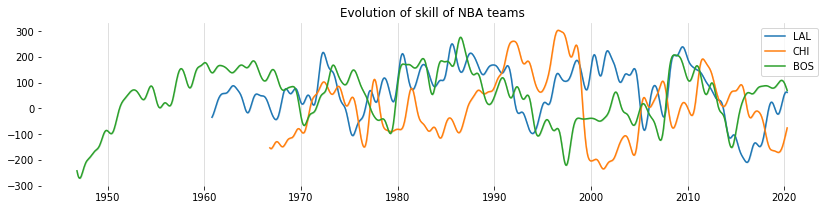

In [10]:
plot_skills(['LAL', 'CHI', 'BOS'])

In [11]:
def predict_result(team1, team2, t):
    if isinstance(t, list):
        # make multiple predictions for those 2 teams
        if isinstance(t[0], str):
            for i in range(len(t)):
                t[i] = datetime.fromisoformat(t[i]).timestamp()
        
        t = np.array(t).reshape(-1, 1)
        
        skills1 = gprs[team1].predict(t)
        skills2 = gprs[team2].predict(t)
        
        res = np.full(len(t), team1)
        res[skills1 < skills2] = team2
        return res
        
    else:
        if isinstance(t, str):
            t = datetime.fromisoformat(t).timestamp()

        t = np.array(t).reshape(-1, 1)
        skill1 = gprs[team1].predict(t)
        skill2 = gprs[team2].predict(t)

        if skill1 > skill2:
            return team1
        else:
            return team2

## Let's check accuracy of our predictor

In [12]:
confussion_matrix = np.zeros((2, 2))

for i in tqdm(range(len(df))):
    row = df.iloc[i]
    if row['season'] < 1950:
        continue
    
    if row['score1'] > row['score2']:
        home_w = True
        result = row['team1']
    else:
        home_w = False
        result = row['team2']
    
    pred = predict_result(row['team1'], row['team2'], row['date'])
    
    if home_w:
        if result == pred:
            confussion_matrix[0][0] += 1
        else:
            confussion_matrix[0][1] += 1
    else:
        if result == pred:
            confussion_matrix[1][1] += 1
        else:
            confussion_matrix[1][0] += 1
    

100%|██████████| 69636/69636 [00:34<00:00, 1992.89it/s]


In [13]:
print(f'Confussion matrix:\n{confussion_matrix}\nAccuracy: \
      {np.sum(np.diag(confussion_matrix)) / np.sum(confussion_matrix)}')

Confussion matrix:
[[26829. 15355.]
 [ 7552. 18955.]]
Accuracy:       0.66652108718755


## To know if the predictor provides us wich useful data, check if we'll will make any money betting on every game $10.

In [14]:
games_df = pd.read_csv('data/nba_games_all.csv')
lines_df = pd.read_csv('data/nba_betting_money_line.csv')

In [15]:
games_df = games_df[games_df['is_home'] == 't']
book = lines_df['book_name'].value_counts().index[0]
lines_df = lines_df[lines_df['book_name'] == book]

In [16]:
lg_df = games_df.merge(lines_df, on='game_id')
lg_df.head()

,game_id,game_date,matchup,team_id_x,is_home,wl,w,l,w_pct,min,...,a_team_id_x,season_year,season_type,season,book_name,book_id,team_id_y,a_team_id_y,price1,price2
0,20800558,2009-01-12,IND @ UTA,1610612762,t,W,23.0,15.0,0.605,240,...,1610612754,2008,Regular Season,2008-09,5Dimes,19,1610612754,1610612762,448.0,-520.0
1,20800344,2008-12-13,ORL @ UTA,1610612762,t,L,15.0,10.0,0.600,240,...,1610612753,2008,Regular Season,2008-09,5Dimes,19,1610612753,1610612762,325.0,-400.0
2,20801116,2009-04-01,WAS @ MEM,1610612763,t,W,20.0,54.0,0.270,240,...,1610612764,2008,Regular Season,2008-09,5Dimes,19,1610612764,1610612763,132.0,-142.0
3,20800762,2009-02-09,NOH @ MEM,1610612763,t,W,15.0,36.0,0.294,240,...,1610612740,2008,Regular Season,2008-09,5Dimes,19,1610612740,1610612763,153.0,-163.0
4,20800642,2009-01-24,NJN @ MEM,1610612763,t,L,11.0,32.0,0.256,240,...,1610612751,2008,Regular Season,2008-09,5Dimes,19,1610612751,1610612763,-114.0,104.0


In [29]:
def money_boost(line):
    if line < 0:
        return 100 * (our_bet / -line)
    else:
        return line / (100 / our_bet)
    
money_s = defaultdict(int)
money_d = defaultdict(int)
our_bet = 10
n = 0
opt_max_line = 250

for i in tqdm(range(len(lg_df)), position=0, leave=True):
    row = lg_df.iloc[i]
    t = row['game_date']
    s = row['season']
    t1, t2 = row['matchup'].split(' @ ')
    
    if t1 not in teams or t2 not in teams:
        continue
        
    if row['price1'] > opt_max_line or row['price2'] > opt_max_line:  # taking only '50:50' bets
        continue
    
    pred = predict_result(t1, t2, t)
    n += 1
    
    if pred == t2 and row['wl'] == 'W':
        money_d[t] += money_boost(row['price2'])
        money_s[s] += money_boost(row['price2'])
    elif pred == t1 and row['wl'] == 'L':
        money_d[s] += money_boost(row['price1'])
        money_s[s] += money_boost(row['price1'])
    else:
        money_d[s] -= our_bet
        money_s[s] -= our_bet

100%|██████████| 14894/14894 [00:06<00:00, 2162.61it/s]


In [30]:
print(f'Total money made: {sum(money_d.values())}, first bet placed: {min(money_d.keys())}, last: {max(money_d.keys())}')
print(f'Average money made from one bet: {sum(money_s.values()) / n}, bets taken: {n}')
print(f'Average money made in one day: {sum(money_d.values()) / len(money_d.values())}')
print(f'Average money made in a season: {sum(money_s.values()) / len(money_s.values())}')

Total money made: 4838.852382689764, first bet placed: 2006-07, last: 2018-05-24
Average money made from one bet: 0.6429514194379164, bets taken: 7526
Average money made in one day: 3.995749283806577
Average money made in a season: 403.2376985574799


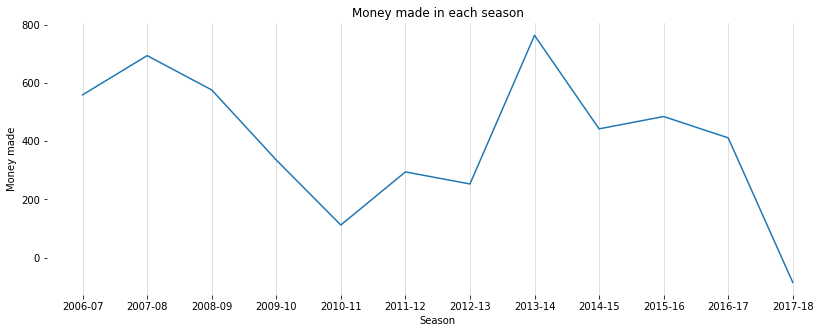

In [31]:
x, y = [], []
for k, v in money_s.items():
    x.append(k)
    y.append(v)
    
x = np.array(x)
y = np.array(y)
idx = np.argsort(x)
x = x[idx]
y = y[idx]

fig, ax = plt.subplots(figsize=(14, 5))
ax.set_title('Money made in each season')
ax.set_xlabel('Season')
ax.set_ylabel('Money made')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', alpha=0.5)

ax.plot(x, y)